# 2100 l/mm Grating reference lamp

In [2]:
_file = 'ecfzst_0280_Calibration-Star_26-11-2020_comp_389.fits'


In [3]:
from ccdproc import CCDData

from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


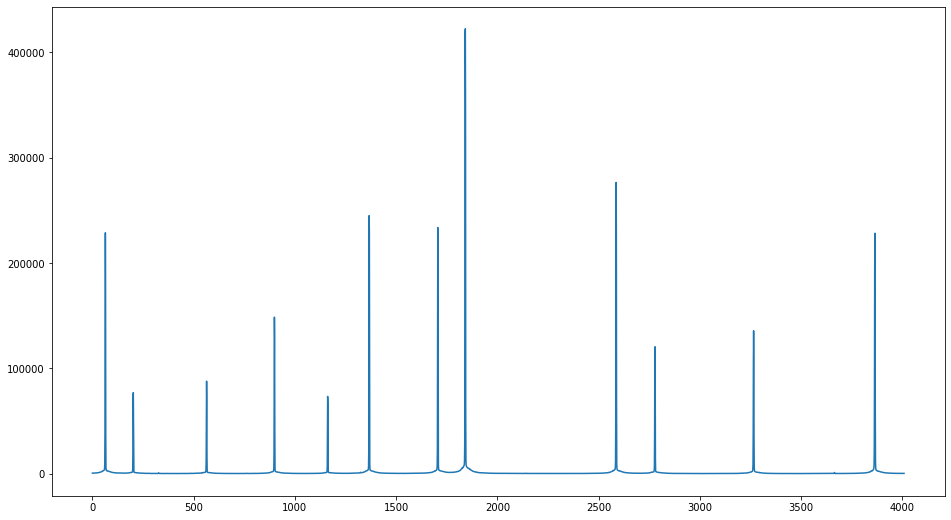

In [4]:
ccd = CCDData.read(_file, unit='adu')

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(ccd.data)

In [5]:
from goodman_pipeline.core import get_lines_in_lamp, get_spectral_characteristics

In [6]:
lines = get_lines_in_lamp(ccd=ccd)

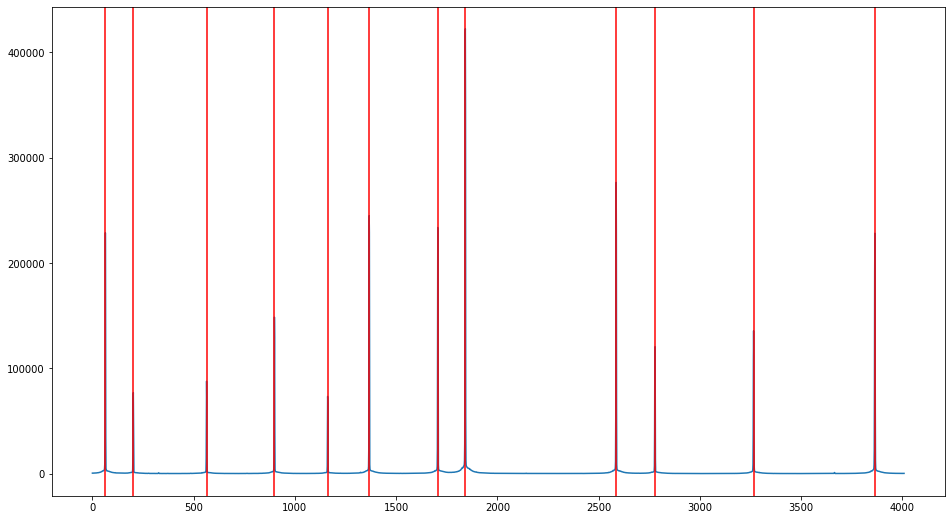

In [7]:
fig_2, ax_2 = plt.subplots(figsize=(16,9))
ax_2.plot(ccd.data)
for _line in lines:
    ax_2.axvline(_line, color='r')

In [8]:
import re
def new_get_spectral_characteristics(ccd, pixel_size, instrument_focal_length):
    """Calculates some Goodman's specific spectroscopic values.

    From the header value for Grating, Grating Angle and Camera Angle it is
    possible to estimate what are the wavelength values at the edges as well
    as in the center. It was necessary to add offsets though, since the
    formulas provided are slightly off. The values are only an estimate.

    Args:
        ccd (CCDData): Lamp `ccdproc.CCDData` instance
        pixel_size (float): Pixel size in microns
        instrument_focal_length (float): Instrument focal length

    Returns:
        spectral_characteristics (dict): Contains the following parameters:
            center: Center Wavelength
            blue: Blue limit in Angstrom
            red: Red limit in Angstrom
            alpha: Angle
            beta: Angle
            pix1: Pixel One
            pix2: Pixel Two


    """
    # TODO (simon): find a definite solution for this, this only work
    # TODO (simon): (a little) for one configuration
    blue_correction_factor = -50 * u.angstrom * 0.
    red_correction_factor = -37 * u.angstrom * 0.

    grating_frequency = float(re.sub('[A-Za-z_-]',
                                     '',
                                     ccd.header['GRATING'])) / u.mm

    grating_angle = float(ccd.header['GRT_ANG']) * u.deg
    camera_angle = float(ccd.header['CAM_ANG']) * u.deg

    # serial binning - dispersion binning
    # parallel binning - spatial binning
    serial_binning, parallel_binning = [
        int(x) for x in ccd.header['CCDSUM'].split()]

    pixel_count = len(ccd.data)
    # Calculations
    # TODO (simon): Check whether is necessary to remove the
    # TODO (simon): slit_offset variable
    alpha = grating_angle.to(u.rad)
    beta = camera_angle.to(u.rad) - grating_angle.to(u.rad)

    center_wavelength = (np.sin(alpha) + np.sin(beta)) / grating_frequency

    limit_angle = np.arctan(pixel_count * ((pixel_size * serial_binning) / instrument_focal_length) / 2)

    blue_limit = ((np.sin(alpha) + np.sin(beta - limit_angle.to(u.rad))) / grating_frequency).to(u.angstrom) + blue_correction_factor

    red_limit = ((np.sin(alpha) + np.sin(beta + limit_angle.to(u.rad))) / grating_frequency).to(u.angstrom) + red_correction_factor

    pixel_one = 0
    pixel_two = 0
    print(
        'Center Wavelength : {:.3f} Blue Limit : '
        '{:.3f} Red Limit : {:.3f} '.format(center_wavelength.to(u.angstrom),
                                            blue_limit,
                                            red_limit))

    spectral_characteristics = {'center': center_wavelength,
                                'blue': blue_limit,
                                'red': red_limit,
                                'alpha': alpha,
                                'beta': beta,
                                'pix1': pixel_one,
                                'pix2': pixel_two}
    return spectral_characteristics


In [36]:
import astropy.units as u
import json
pixel_size = 15 * u.micrometer
goodman_focal_length = 377.3 * u.mm
spec_dict = get_spectral_characteristics(ccd=ccd, pixel_size=pixel_size, instrument_focal_length=goodman_focal_length)

In [37]:
spec_dict

{'center': <Quantity 0.00065001 mm>,
 'blue': <Quantity 6163.27109492 Angstrom>,
 'red': <Quantity 6729.36247937 Angstrom>,
 'alpha': <Quantity 0.75118796 rad>,
 'beta': <Quantity 0.75119418 rad>,
 'pix1': 0,
 'pix2': 0}

In [38]:
print(ccd.data.shape)
spec_dict['center'].to('Angstrom').value

(4010,)


6500.093047683469

In [39]:
from astropy.modeling import models, fitting

x_points_pixel = [0, ccd.data.shape[0]/2., ccd.data.shape[0]]
x_points_angstrom_theoretical = [spec_dict['blue'].value, spec_dict['center'].to('Angstrom').value,spec_dict['red'].value]
x_points_angstrom = [6143.0626,
                     6163.5939,
                     6217.2812,
                     6266.4950,
                     6304.7889,
                     6334.4278,     
                     6382.9917,
                     6402.2480,
                     6506.5281,
                     6532.8822,
                     6598.9529,
                     6678.2762]

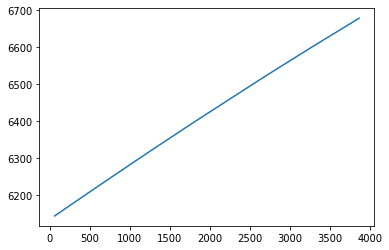

In [40]:
plt.plot(lines, x_points_angstrom)

In [41]:
from goodman_pipeline.wcs import WCS
import numpy as np

wcs = WCS()

theoretical_solution = wcs.fit(physical=x_points_pixel, wavelength=x_points_angstrom_theoretical, model_name='linear')
empirical_solution = wcs.fit(physical=lines, wavelength=x_points_angstrom, model_name='chebyshev')

In [45]:
def add_matched_line_record(ccd, pixels, angstrom):
    if len(pixels) == len(angstrom):
        last_added = 'GSP_WREJ'
        for i in range(len(pixels)):
            keyword_name = f"GSP_P{i + 1:03}"
            ccd.header.set(keyword_name, 
                           value=pixels[i], 
                           comment="Line location in pixel value",
                           after=last_added)
            last_added = keyword_name
        for i in range(len(angstrom)):
            keyword_name = f"GSP_A{i + 1:03}"
            ccd.header.set(keyword_name, 
                           value=angstrom[i], 
                           comment="Line location in angstrom value",
                           after=last_added)
            last_added = keyword_name
        return ccd

        
ccd = add_matched_line_record(ccd, lines, x_points_angstrom)
ccd = wcs.write_gsp_wcs(ccd, empirical_solution)
new_name = f"goodman_comp_{ccd.header['WAVMODE']}_{ccd.header['FILTER2']}_{'HgArNe'}.fits"
ccd.write(new_name, overwrite=True)
print(new_name)
ccd.header

goodman_comp_2100_650_GG455_HgArNe.fits


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                 4010                                                  
DATE-OBS= '2020-11-26T00:52:10.819' / DATE-OBS Format: YYYY-MM-DDThh:mm:ss.sss  
DATE    = '2020-11-26'         / Date Format is YYYY-MM-DD                      
TIME    = '00:52:10.819 to 00:52:11.323' / ~ Start & Stop of Exposure           
N_PRM0  =                   59 / Status                                         
PG0_0   =                24624 / Camera Flags,                                  
PG0_1   =          2147483.647 / Camera Up Time, HH:MM:SS.sss                   
PG0_2   =                    0 / Continuous Clear Mode,                         
PG0_3   =                4.476 / Frame Clear Time, HH:MM:SS.sss                 
PG0_4   =                4.4

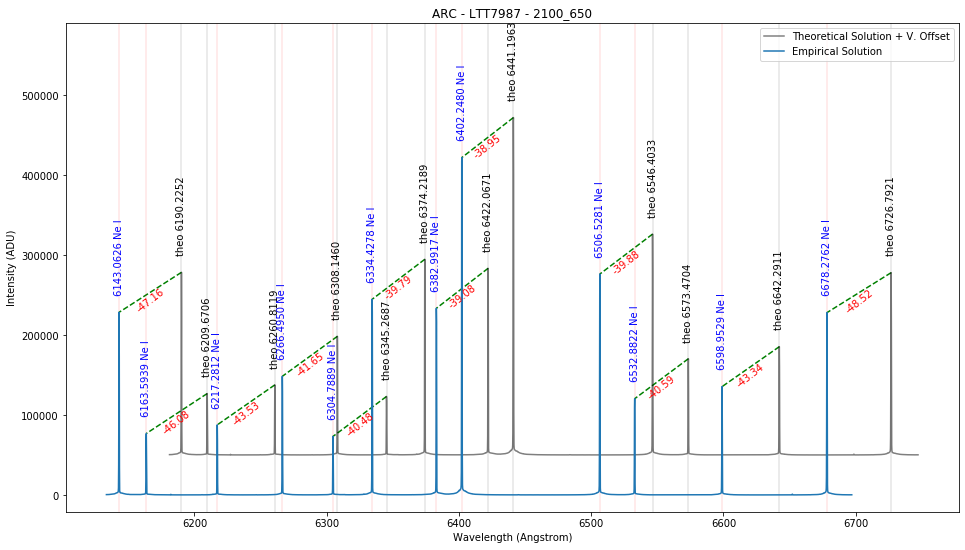

In [43]:
fig3, ax3 = plt.subplots(figsize=(16, 9))

ax3.set_title(f"{ccd.header['OBSTYPE']} - {ccd.header['OBJECT']} - {ccd.header['WAVMODE']}")
top_limit = 1.4 * ccd.data.max()
bottom_limit = ccd.data.min() - 0.05 * ccd.data.max()
ax3.set_ylim(bottom_limit, top_limit)
for i in range(len(lines)):
    _line = lines[i]
    # Theoretical
    ax3.axvline(theoretical_solution(_line), color='k', alpha=0.1)
    t_text = f"theo {theoretical_solution(_line):.4f}"
    t_text_x = theoretical_solution(_line)
    t_text_y = np.max((ccd.data[int(np.floor(_line))], ccd.data[int(np.ceil(_line))]))
    t_y_offset = 0.05 * ccd.data.max() + 50000.
    
    ax3.text(t_text_x, t_text_y + t_y_offset, t_text, rotation=90, verticalalignment='bottom', horizontalalignment='center')
    
#     Empirical Solution
    ax3.axvline(empirical_solution(_line), color='r', alpha=0.1)
    text = f"{x_points_angstrom[i]:.4f} Ne I"
    text_x = empirical_solution(_line)
    text_y = np.max((ccd.data[int(np.floor(_line))], ccd.data[int(np.ceil(_line))]))
    y_offset = 0.05 * ccd.data.max()
    ax3.text(text_x, text_y + y_offset, text, color='b', rotation=90, verticalalignment='bottom', horizontalalignment='center')
    
    ax3.plot([t_text_x, text_x], [t_text_y + 50000. , text_y], color='g', linestyle='dashed')
    ax3.text((t_text_x + text_x)/2., text_y, f"{x_points_angstrom[i] - theoretical_solution(_line):.2f}", color='r', horizontalalignment='center', rotation=38)
ax3.plot(theoretical_solution(range(ccd.data.shape[0])), ccd.data + 50000., color='k', alpha=0.5, label='Theoretical Solution + V. Offset')
ax3.plot(empirical_solution(range(ccd.data.shape[0])), ccd.data, label='Empirical Solution')
ax3.set_ylabel('Intensity (ADU)')
ax3.set_xlabel('Wavelength (Angstrom)')
ax3.legend(loc='best')
# plt.tight_layout()
fig3.savefig('2100_650_Grating_current_method.pdf')


In [44]:
' '.join([f"{l:.06f} {theoretical_solution(l):.06f}" for l in lines])

'63.956298 6190.225221 201.700670 6209.670583 563.968348 6260.811882 899.267549 6308.146044 1162.231834 6345.268692 1367.304971 6374.218850 1706.245895 6422.067114 1841.750338 6441.196265 2587.001598 6546.403327 2778.735374 6573.470369 3266.238495 6642.291146 3864.814575 6726.792085'

In [17]:
#   63.956298 6190.225221 -> 6143.0626 Ne I
#  201.700670 6209.670583 -> 6163.5939 Ne I
#  563.968348 6260.811882 -> 6217.2812 Ne I
#  899.267549 6308.146044 -> 6266.4950 Ne I
# 1162.231834 6345.268692 -> 6304.7889 Ne I
# 1367.304971 6374.218850 -> 6334.4278 Ne I
# 1706.245895 6422.067114 -> 6382.9917 Ne I
# 1841.750338 6441.196265 -> 6402.2480 Ne I
# 2587.001598 6546.403327 -> 6506.5281 Ne I
# 2778.735374 6573.470369 -> 6532.8822 Ne I
# 3266.238495 6642.291146 -> 6598.9529 Ne I
# 3864.814575 6726.792085 -> 6678.2762 Ne I
ll = [6143.0626,
      6163.5939,
      6217.2812,
      6266.4950,
      6304.7889,
      6334.4278,
      6382.9917,
      6402.2480,
      6506.5281,
      6532.8822,
      6598.9529,
      6678.2762]

In [ ]:
# 5489.0273 -> 5460.7350 Hg I (5495.874 Ar I)
# 5806.3959 -> 5769.5980 Hg I
# 5828.9028 -> 5790.6630 Hg I